In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
import time
import cv2
import supervision as sv


In [12]:
# mac optimization codes
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

import tensorflow as tf
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))

tensor([1.], device='mps:0')
/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-08 00:00:48.310998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-08 00:00:48.311089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
#Load the Dataset

CELEBA_DATA_PATH = './Data/celeba'
IMG_PATH = os.path.join(CELEBA_DATA_PATH, 'img_align_celeba/img_align_celeba')
ATTR_PATH = os.path.join(CELEBA_DATA_PATH,'list_attr_celeba.csv')
LANDMARKS_PATH = os.path.join(CELEBA_DATA_PATH,'list_landmarks_align_celeba.csv')
PARTITION_PATH = os.path.join(CELEBA_DATA_PATH,'list_eval_partition.csv')
BBOX_PATH = os.path.join(CELEBA_DATA_PATH,'list_bbox_celeba.csv')


def getImagePath(image_id):
    return os.path.join(IMG_PATH,image_id)


In [14]:
attributes_df = pd.read_csv(ATTR_PATH)
partition_df = pd.read_csv(PARTITION_PATH)
bbox_df = pd.read_csv(BBOX_PATH)

gender_age_df = attributes_df[['image_id', 'Male', 'Young']].copy()
gender_age_df.rename(columns={'Male': 'Gender', 'Young': 'Age'}, inplace=True)

gender_age_df['Gender'] = gender_age_df['Gender'].map({1: 'Male', -1: 'Female'})
gender_age_df['Age'] = gender_age_df['Age'].map({1: 'Young', -1: 'Old'})
merged_df = gender_age_df.merge(partition_df, left_on='image_id', right_on='image_id')
merged_df = merged_df.merge(bbox_df, left_on='image_id', right_on='image_id')
merged_df.head()

,image_id,Gender,Age,partition,x_1,y_1,width,height
0,000001.jpg,Female,Young,0,95,71,226,313
1,000002.jpg,Female,Young,0,72,94,221,306
2,000003.jpg,Male,Young,0,216,59,91,126
3,000004.jpg,Female,Young,0,622,257,564,781
4,000005.jpg,Female,Young,0,236,109,120,166


In [15]:
gender_only_df = merged_df.drop('Age', axis=1)

In [16]:
train_df = gender_only_df[gender_only_df['partition'] == 0]
val_df = gender_only_df[gender_only_df['partition'] == 1]
test_df = gender_only_df[gender_only_df['partition'] == 2]
(train_df.shape[0], val_df.shape[0], test_df.shape[0])


(162770, 19867, 19962)

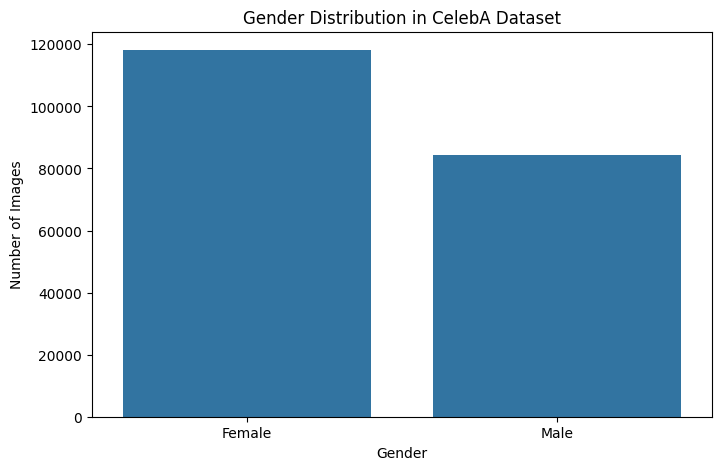

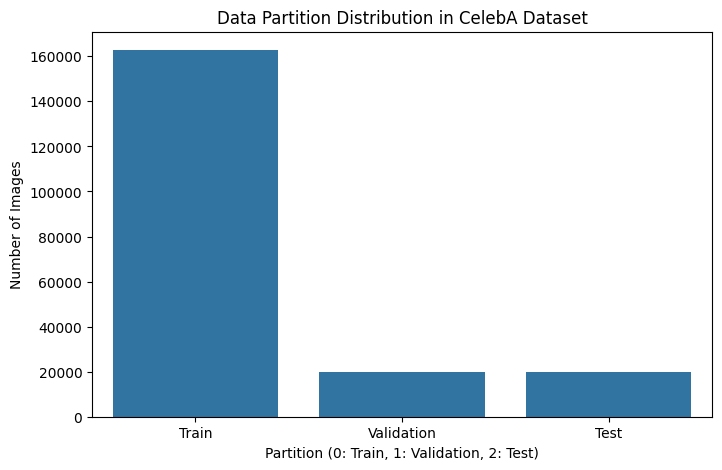

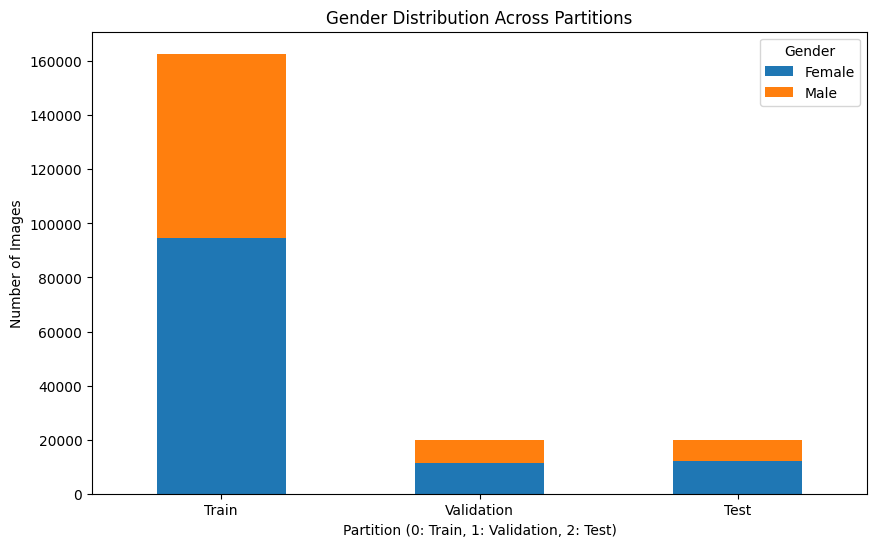

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combining the three dataframes for exploratory analysis
combined_df = pd.concat([train_df, val_df, test_df])

# Explore the overall gender distribution
gender_distribution = combined_df['Gender'].value_counts()

# Plotting the gender distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values)
plt.title('Gender Distribution in CelebA Dataset')
plt.xlabel('Gender')
plt.ylabel('Number of Images')
plt.show()

# Explore the distribution across partitions
partition_distribution = combined_df['partition'].value_counts().sort_index()

# Plotting the partition distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=partition_distribution.index, y=partition_distribution.values)
plt.title('Data Partition Distribution in CelebA Dataset')
plt.xlabel('Partition (0: Train, 1: Validation, 2: Test)')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1, 2], labels=['Train', 'Validation', 'Test'])
plt.show()

# Count the number of male and female in each partition
gender_partition_counts = combined_df.groupby(['partition', 'Gender']).size().unstack(fill_value=0)

# Plotting the gender distribution across partitions
gender_partition_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Gender Distribution Across Partitions')
plt.xlabel('Partition (0: Train, 1: Validation, 2: Test)')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1, 2], labels=['Train', 'Validation', 'Test'], rotation=0)
plt.legend(title='Gender')
plt.show()


## Bounding boxes provided in CelebA are not good enough
To improve accuracy of segmentation, we want to use bounding boxes to narrow down the search and get a more accurate result

However using the bounding boxes that are labelled by CelebA, we see that the bounding boxes are not too accurate.

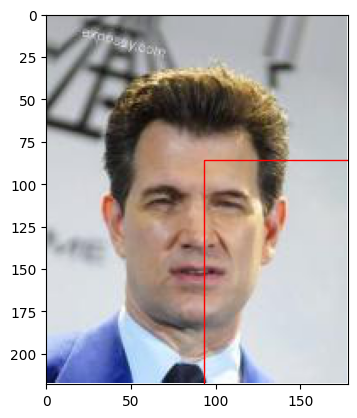

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

test = merged_df.loc[14]
image = getImagePath(test['image_id'])
xyxy = [test['x_1'], test['y_1'], test['width'], test['height']]

# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = getImagePath(test['image_id'])
image = io.imread(image_path)

# Bounding box coordinates and dimensions
bbox = xyxy

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Set the x and y axis limits to match the image size if needed
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)  # Y-axis is inverted for images

# Show the plot with the bounding box
plt.show()


## Tweaking Bounding Box generation and segmentation with YOLOV8 and Mobile SAM

We decided to use yolov8 to generate more accurate bounding boxes, and used mobile SAM to generate masks quickly.  

In [44]:
import cv2
from ultralytics import YOLO, SAM
import supervision as sv
from PIL import Image

CURRENT_DIR = os.getcwd()
test = merged_df.loc[43]
SOURCE_IMAGE_PATH = getImagePath(test['image_id'])
image = cv2.imread(SOURCE_IMAGE_PATH)

model = YOLO('yolov8s.pt')
person_class_index = 0 # ultralytics class dictionary
results= model.predict(image, conf=0.5, classes=[person_class_index])
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]
print(bbox)


image = cv2.cvtColor(cv2.imread(SOURCE_IMAGE_PATH), cv2.COLOR_BGR2RGB)
mobile_sam_model = SAM('mobile_sam.pt')
sam_output = mobile_sam_model.predict(image, bboxes=bbox, iou=0.9 )
for result in sam_output:
    masks = result.masks
mask_object = sam_output[0].masks
mask_tensor = mask_object.data
mask_np = mask_tensor.numpy()


0: 640x544 1 person, 99.1ms
Speed: 2.1ms preprocess, 99.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


[5.76775598526001, 13.969616889953613, 177.4081573486328, 217.47906494140625]



0: 1024x1024 574.3ms
Speed: 7.6ms preprocess, 574.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


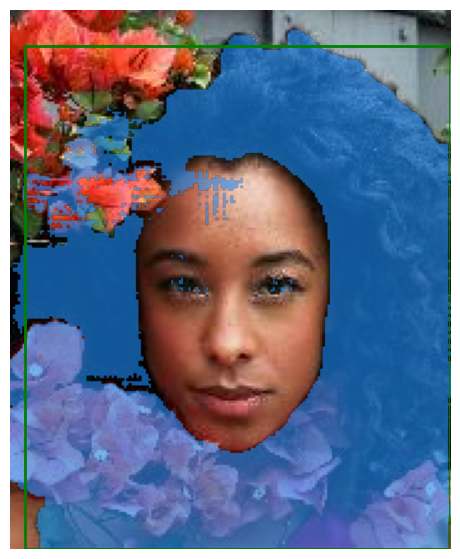

In [45]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
    
    
import numpy as np
import matplotlib.pyplot as plt

input_box = np.array(bbox)
plt.figure(figsize=(7, 7))
plt.imshow(image)
show_mask(mask_np, plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

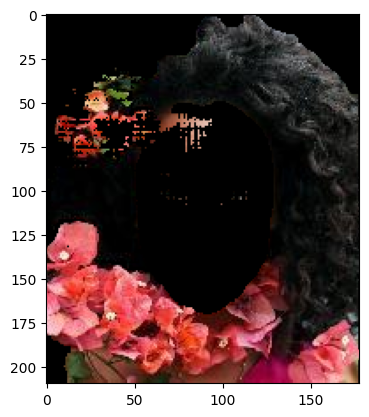

<Figure size 700x700 with 0 Axes>

In [46]:
mask_2d = mask_np.squeeze(axis=0)
# Ensure the mask is the same size as the image
masked_image = np.zeros_like(image)
for c in range(image.shape[2]):  # Assuming image has 3 channels
    masked_image[..., c] = image[..., c] * mask_2d

y_indices, x_indices = np.where(mask_2d)
x_min, x_max = x_indices.min(), x_indices.max()
y_min, y_max = y_indices.min(), y_indices.max()
cropped_image = masked_image[y_min:y_max+1, x_min:x_max+1]

plt.imshow(cropped_image)
plt.figure(figsize=(7, 7))
plt.show()

## Resize to NN input dims & Normalise pixel values

In [17]:
resize_dims = (224, 224)  # Example for a network expecting 224x224x3 input
resized_image = cv2.resize(cropped_image, resize_dims)
normalized_image = resized_image / 255.0  # Scale pixel values to [0, 1]
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB) #convert to rgb from cv2 bgr

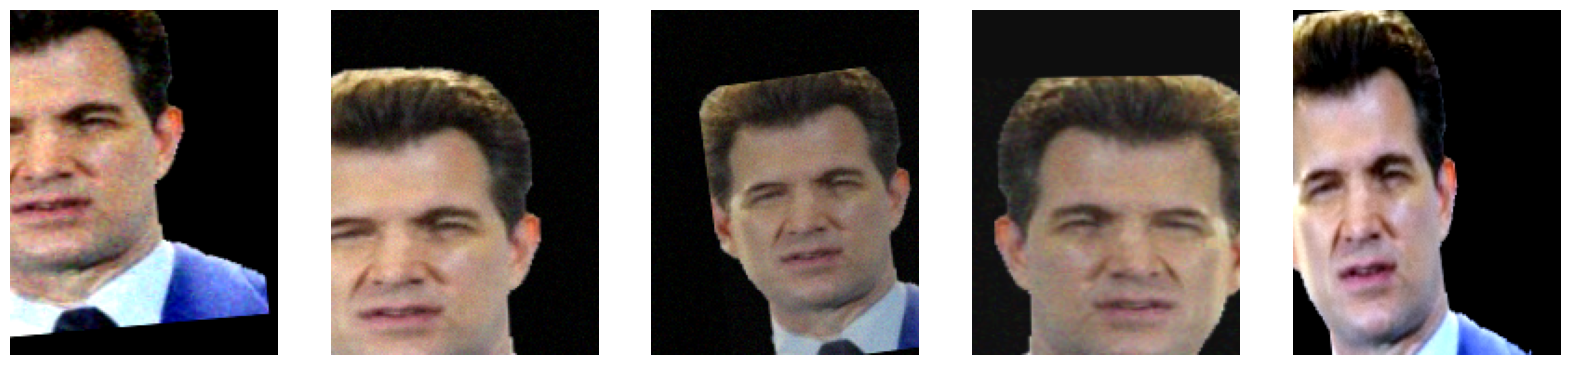

In [15]:
# This is an example using the imgaug library, but you can use any other library or custom code
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Crop(percent=(0, 0.1)),  # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add Gaussian noise.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)  # apply augmenters in random order

augmented_images = [seq(image=cropped_image) for _ in range(5)]

# Display the augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img in zip(axes, augmented_images):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert back to RGB for displaying
    ax.axis('off')
plt.show()

# Scripts for preprocessing

Export all the previous functions into data_preprocessing.py, and call the script to save our preprocessed images

In [1]:
from ultralytics.utils.torch_utils import select_device
from data_preprocessing import process_partition, load_data
from ultralytics import YOLO, SAM
import imgaug.augmenters as iaa

train_df, val_df, test_df = load_data()
# start from where i last stopped
train_df = train_df.iloc[65090 - 1:]

#change to gpu or empty string to auto-select first avail
selected_device = select_device(device='mps', batch=32, newline=False, verbose=True) 
print(f"Using device: {selected_device}")

# Initialize models
yolo_model = YOLO('yolov8s.pt')
sam_model = SAM('mobile_sam.pt')


augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips
    iaa.Crop(percent=(0, 0.1)),  # Random crops
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)


# Example usage
resize_dims = (224, 224)
train_processed = process_partition(train_df, yolo_model, sam_model, resize_dims, augmenter)
# train_processed = process_partition(val_df, yolo_model, sam_model, resize_dims, augmenter)
# train_processed = process_partition(test_df, yolo_model, sam_model, resize_dims, augmenter)

Ultralytics YOLOv8.0.207 🚀 Python-3.10.13 torch-2.1.0 MPS (Apple M1 Pro)
/Users/kohjunkai/anaconda3/envs/gender_classification/lib/python3.10/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Using device: mps


Processing partition:   0%|              | 30/97681 [00:18<16:51:43,  1.61img/s]


KeyboardInterrupt: 

In [ ]:
# Feature Extraction

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128,128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
X = extract_features(df['image'])

  0%|          | 0/20434 [00:00<?, ?it/s]

In [12]:
X.shape

(20434, 128, 128, 1)

In [13]:
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

Model Creation

In [16]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)


model = Model(inputs=[inputs], outputs=[output_1, output_2])


model.compile(loss=['categorical_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])



In [17]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
 26/511 [>.............................] - ETA: 4:02 - loss: 15.3303 - gender_out_loss: 0.0000e+00 - age_out_loss: 15.3303 - gender_out_accuracy: 0.4832 - age_out_accuracy: 0.0745

KeyboardInterrupt: 

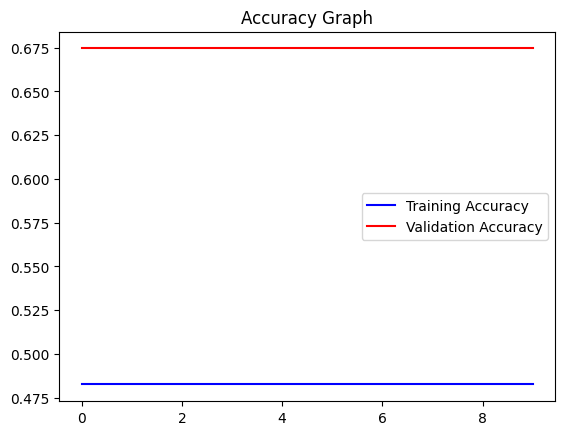

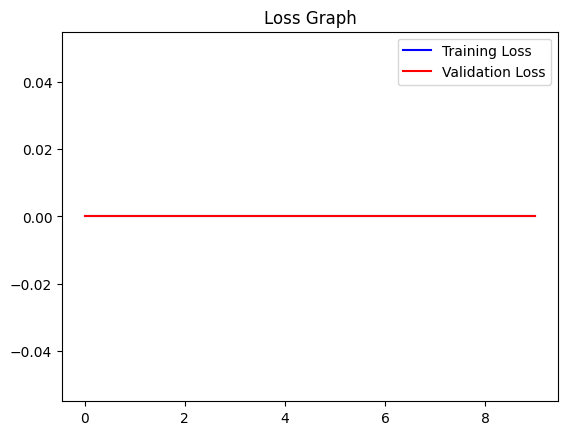

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

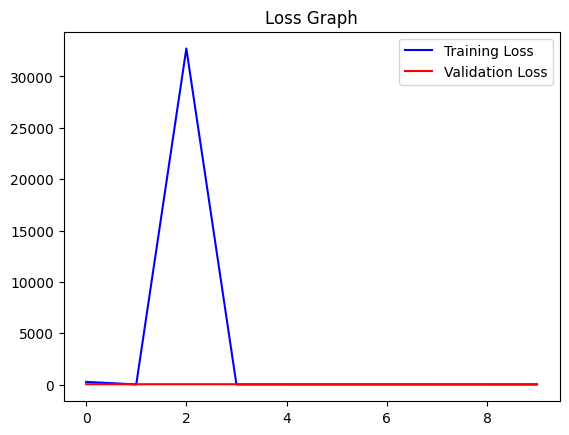

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 1s 1s/step
Male
Predicted Gender: Male Predicted Age: 5


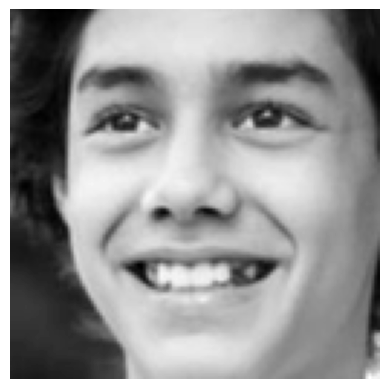

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
print(pred_gender)
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 [==============================] - 0s 97ms/step
Predicted Gender: Male Predicted Age: 5


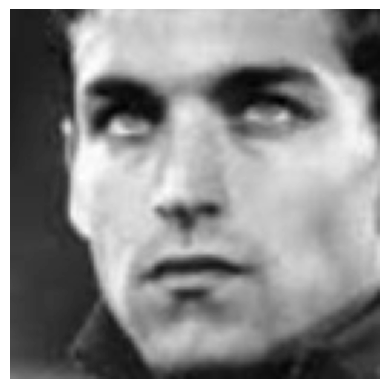

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 113ms/step
Predicted Gender: Male Predicted Age: 5


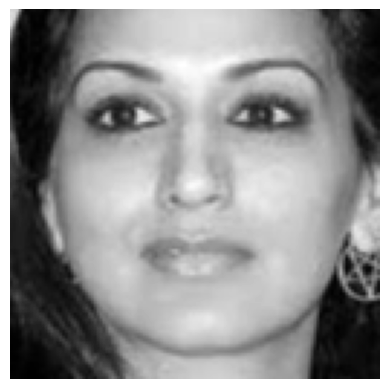

In [ ]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');